# Overclustering experiments with TMM

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import studenttmixture
import matplotlib.pyplot as plt
import sklearn.mixture
import numpy as np
import tqdm
import itertools
import scipy
import scipy.sparse.csgraph
import jax.random as jrandom
import pickle
import pandas

# own code
import corc.datasets2d
from corc.graph_metrics import tmm_gmm_neb
import corc.tmm_plots as tmm_plots
import corc
import corc.graph_metrics.neb

In [3]:
datasets = corc.datasets2d.DATASETS
print(f"there are {len(datasets)} datasets")

there are 19 datasets


In [4]:
data_X, data_y = datasets['Clusterlab10']()
print(f'current dataset has {len(set(data_y.tolist()))} classes')

current dataset has 6 classes


In [5]:
overclustering_n = 15 # always use the same number of clusters
iterations = 50
# levels = [3,6,8,10]
levels = None

# Plot Overview rows

After filtering 15 components, we are left with 12 components


tmm: 100%|██████████| 66/66 [00:32<00:00,  2.06it/s]


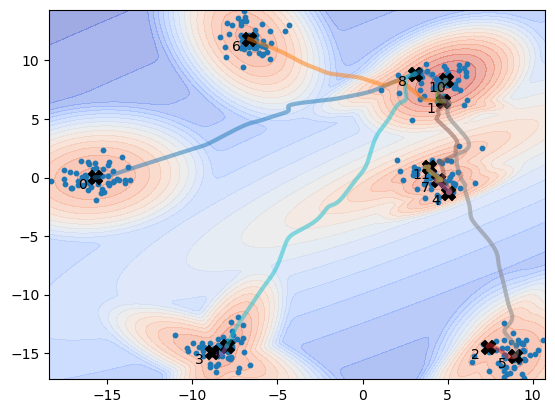

In [6]:
neb_iterations=50
data_X,data_y = datasets['Clusterlab9']()
additional_edges = []
# [(2,10),(0,2),(2,6)]

tmm_model = corc.graph_metrics.neb.NEB(
    latent_dim=2,
    data=data_X,
    labels=data_y,
    optimization_iterations=neb_iterations,
)
tmm_model.fit(data=data_X)
tmm_plots.plot_field(
    data_X=data_X,
    mixture_model=tmm_model.mixture_model,
    paths=tmm_model.paths_,
    selection=tmm_model.compute_mst_edges(tmm_model.raw_adjacency_) + additional_edges,
    levels=20,
    save_path="/tmp/heatmap.pdf"
)


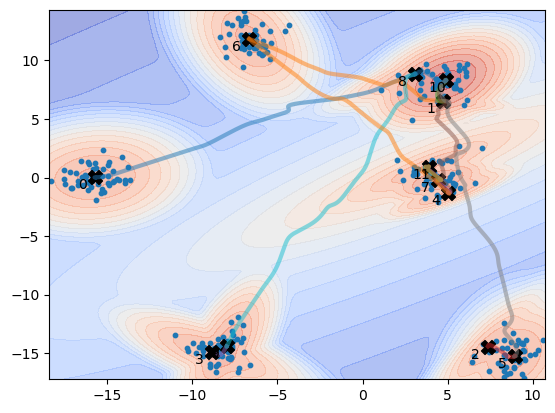

In [7]:
tmm_plots.plot_field(
    data_X=data_X,
    mixture_model=tmm_model.mixture_model,
    paths=tmm_model.paths_,
    selection=tmm_model.compute_mst_edges(tmm_model.raw_adjacency_) + [(4,6)],
    levels=20,
    # save_path="/tmp/heatmap.pdf"
)

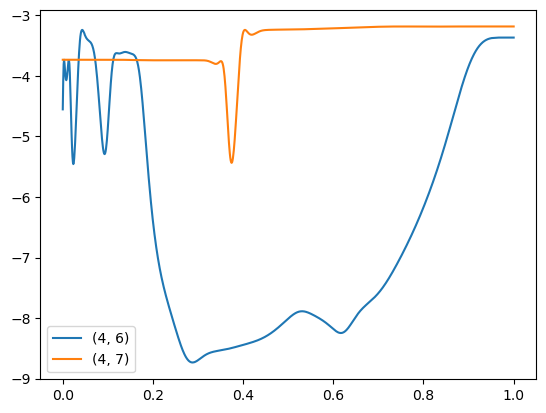

In [8]:
additional_edges = [(4,6),(4,7)]
for edge in additional_edges:
    plt.plot(tmm_model.temps_[edge], tmm_model.logprobs_[edge], label=f"{edge}")
plt.legend()

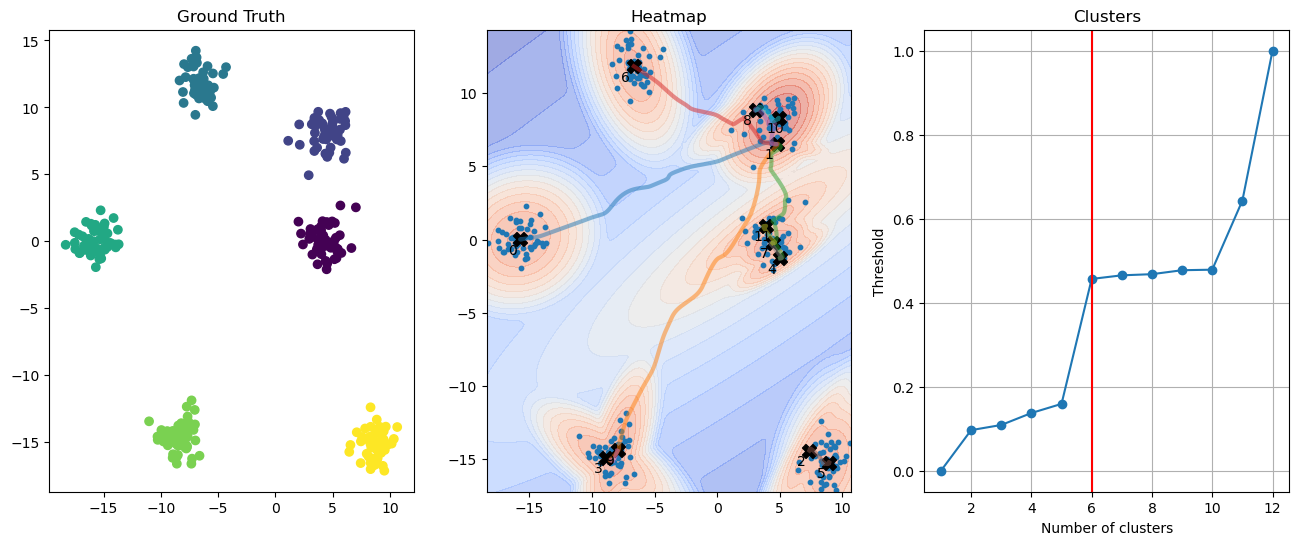

In [10]:
tmm_plots.plot_row(
    data_X=data_X,
    data_y=data_y,
    tmm_model=tmm_model,
)

After filtering 15 components, we are left with 11 components


tmm: 100%|██████████| 55/55 [00:24<00:00,  2.24it/s]


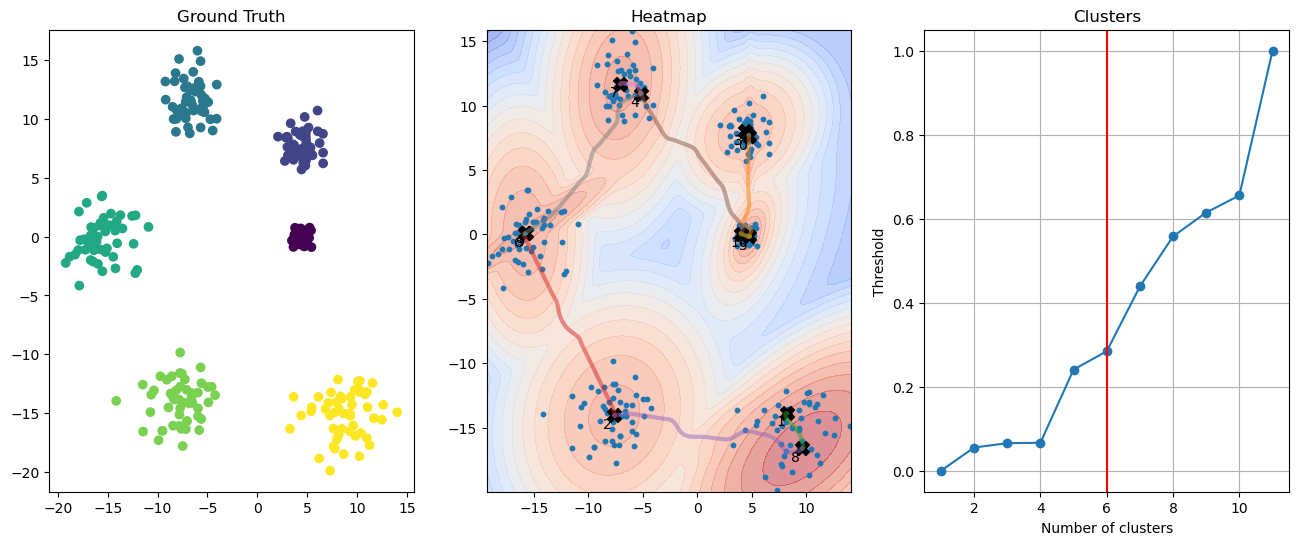

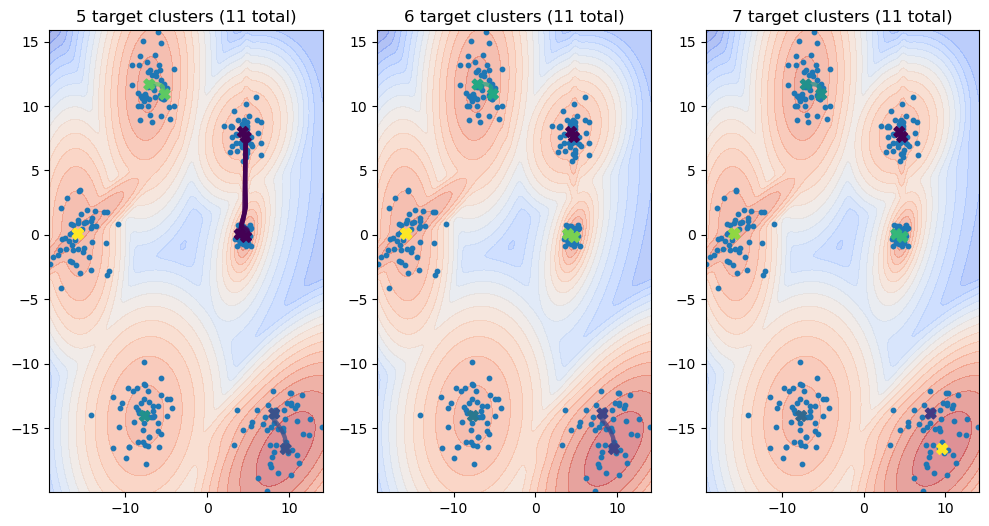

In [20]:
tmm_plots.plot_row_with_computation(data_X, data_y, overclustering_n=overclustering_n, iterations=iterations, levels=levels)

current dataset has 6 classes
After filtering 15 components, we are left with 11 components


tmm: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


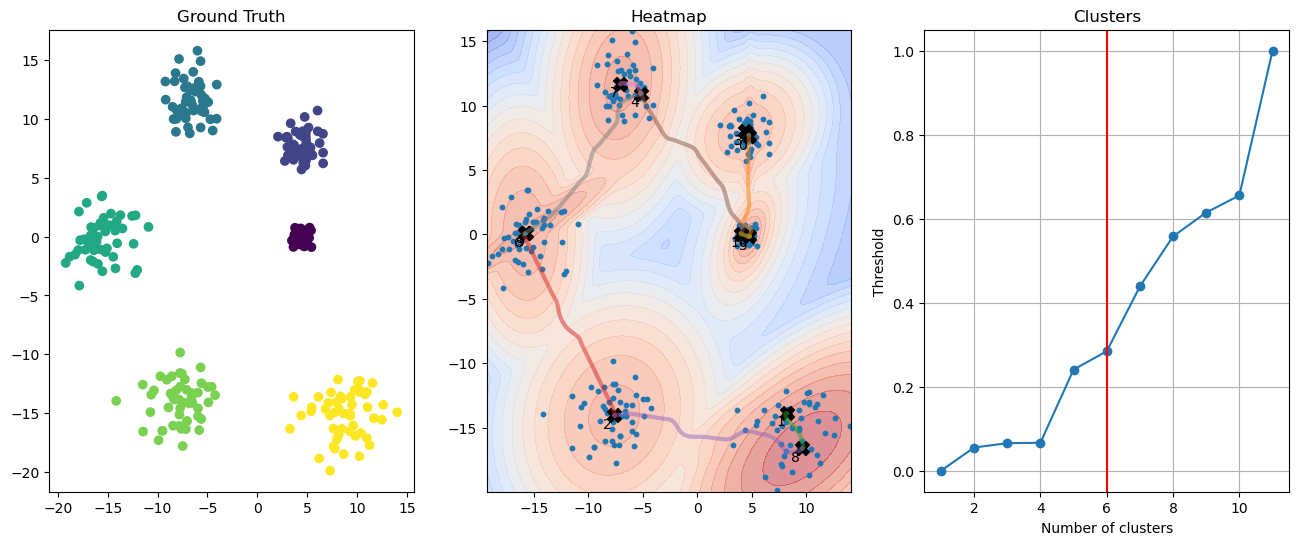

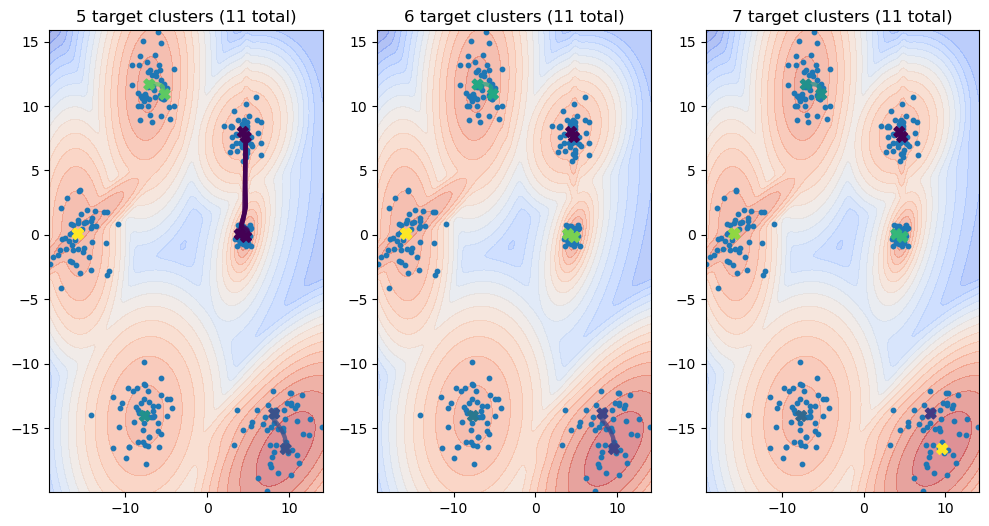

In [19]:
data_X, data_y = datasets['Clusterlab10']()
print(f'current dataset has {len(set(data_y.tolist()))} classes')
tmm_plots.plot_row_with_computation(data_X, data_y, overclustering_n=overclustering_n, iterations=iterations, levels=levels)

current dataset has 6 classes
After filtering 15 components, we are left with 12 components


tmm: 100%|██████████| 66/66 [00:27<00:00,  2.36it/s]


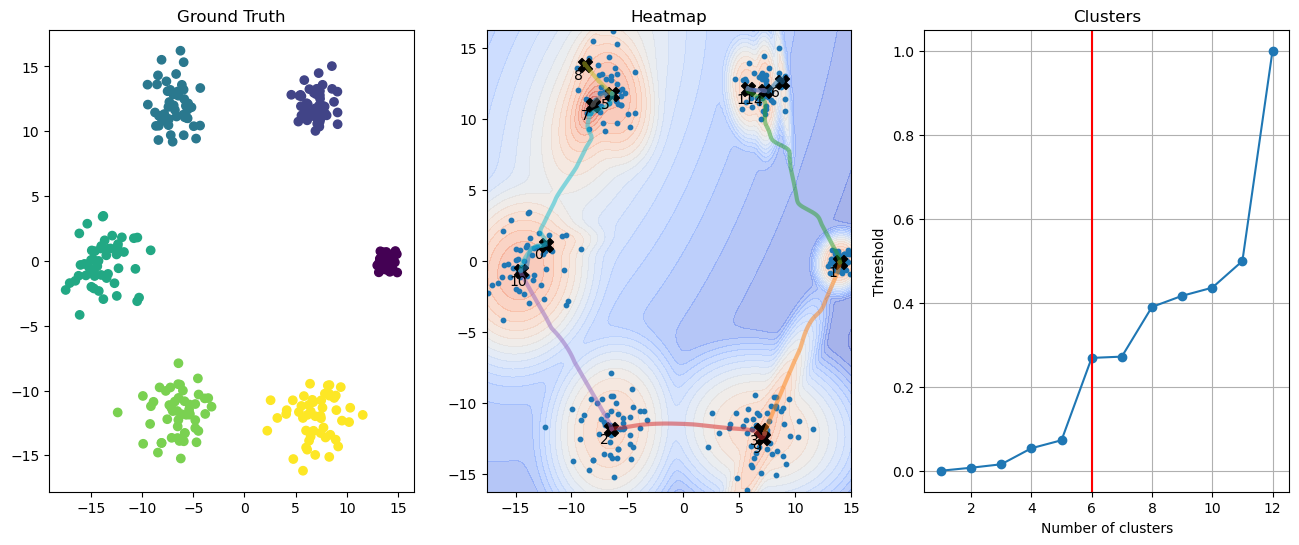

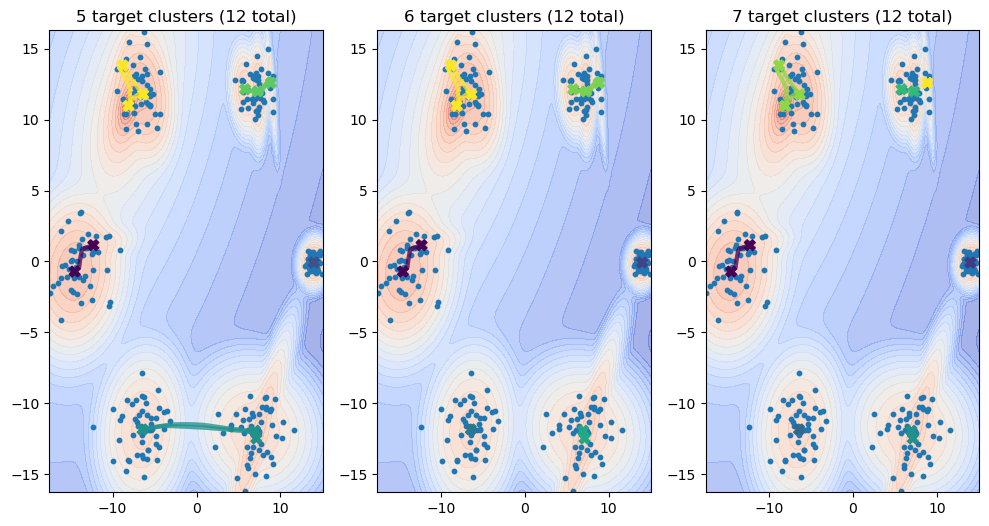

In [18]:
data_X, data_y = datasets['Clusterlab8']()
print(f'current dataset has {len(set(data_y.tolist()))} classes')
tmm_plots.plot_row_with_computation(data_X, data_y, overclustering_n=overclustering_n, iterations=iterations, levels=levels)

# Just plotting paths

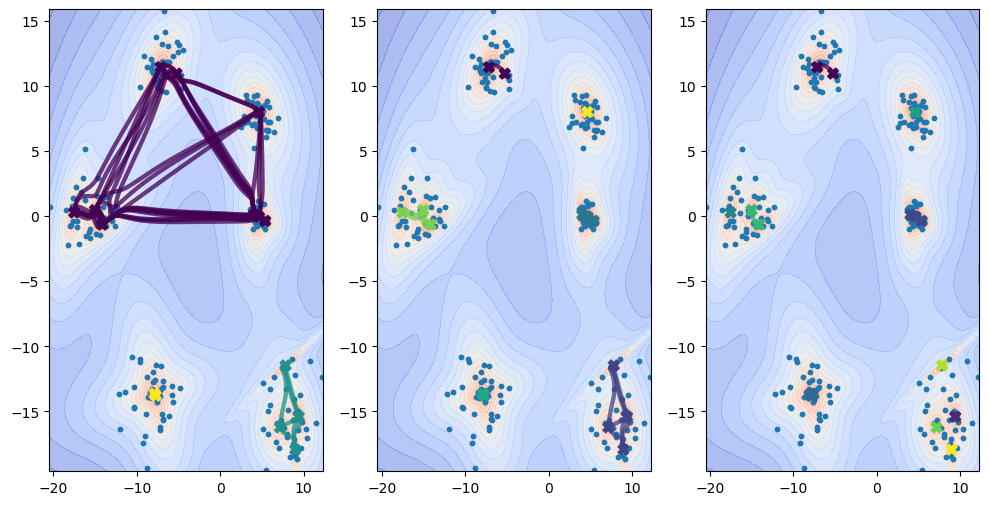

In [184]:
tmm, adjacency, paths, thresholds, cluster_numbers, counts, mst_edges = (
    tmm_plots.computations_for_plot_row(data_X, overclustering_n, iterations=iterations))
tmm_plots.plot_cluster_levels([3,6,10], tmm, data_X, adjacency, paths)

# remainder

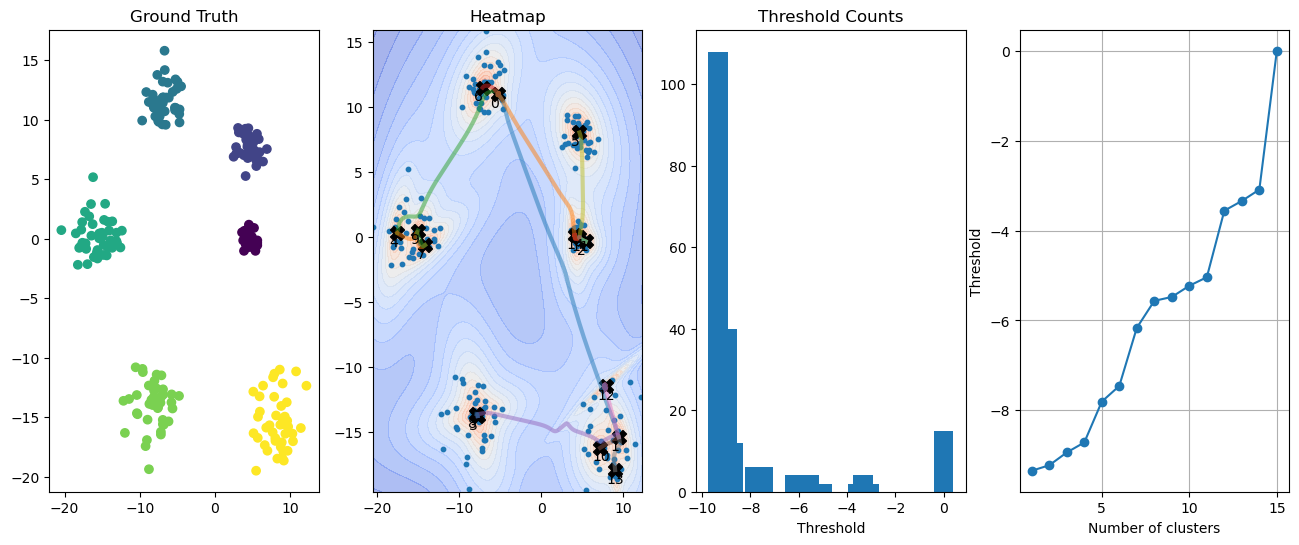

In [120]:
tmm_plots.plot_row(data_X, data_y, paths, thresholds, cluster_numbers, counts, mst_edges)


In [97]:
mst = -scipy.sparse.csgraph.minimum_spanning_tree(-raw_adjacency)
mst

<15x15 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [103]:
rows, cols = mst.nonzero()

In [104]:
entries = list(zip(rows, cols))

In [110]:
np.unique(adjacency, return_counts=True)

(array([-9.34274578, -9.21699429, -8.93087101, -8.71387386, -7.80396128,
        -7.45613623, -6.15004873, -5.55755234, -5.44408989, -5.15639496,
        -5.0372901 , -3.55827522, -3.34112883, -3.08883405,  0.        ]),
 array([108,  16,  40,  12,   6,   6,   4,   4,   2,   2,   2,   2,   4,
          2,  15]))

# transcriptomics

In [4]:
with open('/Users/martin/git/cluster_vs_continuum/paul15_transcriptomics_dataset.pkl', 'rb') as f:
    data = pickle.load(f)
data_X = data.iloc[:,:999]
data_y = data.iloc[:,-1]

In [5]:
tmm = studenttmixture.EMStudentMixture(
            n_components=15,
            n_init=1,
            fixed_df=True,
            df=1.0,
            init_type="k++",
            random_state=42,
            max_iter=10 # default 1000, on mac 7s/iter
        )
tmm.fit(np.array(data_X, dtype=np.float64))

Restart 1 did not converge!
The model did not converge on any of the restarts! Try increasing max_iter or tol or check data for possible issues.


In [5]:
gmm = sklearn.mixture.GaussianMixture(
            n_components=15,
            n_init=1,
            random_state=42,
            init_params='k-means++',
            covariance_type='spherical'
        )
gmm.fit(np.array(data_X, dtype=np.float64))

GaussianMixture(init_params='k-means++', n_components=15, random_state=42)

In [ ]:
gmm2 = sklearn.mixture.GaussianMixture(
            n_components=15,
            n_init=1,
            random_state=42,
            init_params='k-means++',
            covariance_type='full'
        )
gmm2.fit(np.array(data_X, dtype=np.float64))